In [1]:
%load_ext autoreload
%autoreload 2

from nb_002b import *

In [2]:
DATA_PATH = Path('../data')
PATH = DATA_PATH/'cifar10'

In [3]:
data_mean,data_std = map(tensor, ([0.491, 0.482, 0.447], [0.247, 0.243, 0.261]))
cifar_norm = normalize_tfm(mean=data_mean,std=data_std)

In [4]:
tfms = [flip_lr_tfm(p=0.5),
        pad_tfm(padding=4),
        crop_tfm(size=32, row_pct=(0,1.), col_pct=(0,1.))]

In [5]:
bs = 128

In [6]:
train_ds = FilesDataset(PATH/'train')
valid_ds = FilesDataset(PATH/'test')
data = DataBunch(train_ds, valid_ds, bs=bs, train_tfm=tfms+[cifar_norm], valid_tfm=[cifar_norm], num_workers=0)
len(data.train_dl), len(data.valid_dl)

(391, 40)

## Training loop so far

In [7]:
def loss_batch(model, xb, yb, loss_fn, opt=None):
    loss = loss_fn(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

In [8]:
def fit(epochs, model, loss_fn, opt, train_dl, valid_dl):
    for epoch in tnrange(epochs):
        model.train()
        for xb,yb in train_dl:
            loss,_ = loss_batch(model, xb, yb, loss_fn, opt)
            if train_dl.progress_func is not None: train_dl.gen.set_postfix_str(loss)

        model.eval()
        with torch.no_grad():
            losses,nums = zip(*[loss_batch(model, xb, yb, loss_fn)
                                for xb,yb in valid_dl])
        val_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)

        print(epoch, val_loss)

In [9]:
class Learner():
    def __init__(self, data, model):
        self.data,self.model = data,model.to(data.device)

    def fit(self, epochs, lr, opt_fn=optim.SGD):
        opt = opt_fn(self.model.parameters(), lr=lr)
        loss_fn = F.cross_entropy
        fit(epochs, self.model, loss_fn, opt, self.data.train_dl, self.data.valid_dl)

## Model

In [10]:
def conv_layer(ni, nf, ks=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=ks//2),
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True))

class ResLayer(nn.Module):
    def __init__(self, ni):
        super().__init__()
        self.conv1=conv_layer(ni, ni//2, ks=1)
        self.conv2=conv_layer(ni//2, ni, ks=3)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

class Darknet(nn.Module):
    def make_group_layer(self, ch_in, num_blocks, stride=1):
        return [conv_layer(ch_in, ch_in*2,stride=stride)
               ] + [(ResLayer(ch_in*2)) for i in range(num_blocks)]

    def __init__(self, num_blocks, num_classes, nf=32):
        super().__init__()
        layers = [conv_layer(3, nf, ks=3, stride=1)]
        for i,nb in enumerate(num_blocks):
            layers += self.make_group_layer(nf, nb, stride=2-(i==1))
            nf *= 2
        layers += [nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(nf, num_classes)]
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x): return self.layers(x)

In [11]:
model = Darknet([1, 2, 4, 6, 3], num_classes=10, nf=16)

## Setting hyperparameters easily

We want an optimizer with an easy way to set hyperparameters: they're all properties and we define custom setters to handle the different names in pytorch optimizers.

In [12]:
class HPOptimizer():
    
    def __init__(self, params, opt_fn, init_lr):
        self.opt = opt_fn(params, init_lr)
        self._lr = init_lr
        self.opt_keys = list(self.opt.param_groups[0].keys())
        self.opt_keys.remove('params')
        self.read_defaults()
    
    #Pytorch optimizer methods
    def step(self):
        self.opt.step()
    
    def zero_grad(self):
        self.opt.zero_grad()
    
    #Hyperparameters as properties
    @property
    def lr(self): return self._lr

    @lr.setter
    def lr(self, val):
        self.set_val('lr', val)
        self._lr = val
    
    @property
    def mom(self): return self._mom

    @mom.setter
    def mom(self, val):
        if 'momentum' in self.opt_keys: self.set_val('momentum', val)
        elif 'betas' in self.opt_keys:  self.set_val('betas', (val, self._beta))
        self._mom = val
    
    @property
    def beta(self): return self._beta

    @beta.setter
    def beta(self, val):
        if 'betas' in self.opt_keys:    self.set_val('betas', (self._mom,val))
        elif 'alpha' in self.opt_keys:  self.set_val('alpha', val)
        self._beta = val
    
    @property
    def wd(self): return self._wd

    @wd.setter
    def wd(self, val):
        self.set_val('weight_decay', val)
        self._wd = val
    
    #Helper functions
    def read_defaults(self):
        if 'momentum' in self.opt_keys: self._mom = self.opt.param_groups[0]['momentum']
        if 'alpha' in self.opt_keys: self._beta = self.opt.param_groups[0]['alpha']
        if 'betas' in self.opt_keys: self._mom,self._beta = self.opt.param_groups[0]['betas']
        if 'weight_decay' in self.opt_keys: self._wd = self.opt.param_groups[0]['weight_decay']
    
    def set_val(self, key, val):
        for pg in self.opt.param_groups: pg[key] = val

In [13]:
opt_fn = partial(optim.Adam, betas=(0.95,0.99))

In [14]:
opt = HPOptimizer(model.parameters(), opt_fn, 1e-2)

In [15]:
opt.lr, opt.mom, opt.wd, opt.beta

(0.01, 0.95, 0, 0.99)

In [16]:
opt.lr=0.2

In [17]:
opt.lr, opt.mom, opt.wd, opt.beta

(0.2, 0.95, 0, 0.99)

Now that it's easy to set and change the HP in the optimizer, we need a scheduler to change it. To keep the training loop as readable as possible we don't want to handle all of this stuff inside it so we'll use callbacks. 

In [27]:
class Callback():
    def on_train_begin(self): pass         
        #To initiliaze constants in the callback.
    def on_batch_begin(self, xb, yb): return xb, yb 
        #To set HP before the step is done. A look at the input can be useful (set the lr depending on the seq_len in RNNs, 
        #or for reg_functions called in on_backward_begin)
        #Returns xb, yb (which can allow us to modify the input at that step if needed)
    def on_backward_begin(self, loss): return loss
        #Called after the forward pass and the loss has been computed, but before the back propagation.
        #Returns the loss (which can allow us to modify it, for instance for reg functions)
    def on_backward_end(self): pass
        #Called after the back propagation had been done (and the gradients computed) but before the step of the optimizer.
        #Useful for true weight decay in AdamW
    def on_step_end(self): pass
        #Called after the step of the optimizer but before the gradients are zeroed (not sure this one is useful)
    def on_batch_end(self, loss): pass
        #Called at the end of the batch. Can stop the current epoch by returning True
    def on_epoch_end(self, val_loss): pass
        #Called at the end of an epoch. Can stop the training by returning True.

#on_epoch_begin isn't really useful since we have on_train_begin for epoch 0 and on_epoch_end for the others
#does on_train_end make sense?

The idea is to have a callback between every line of the training loop, that way everything we need to add will be treated there and not inside.

In [28]:
def loss_batch(model, xb, yb, loss_fn, opt=None, callbacks=[]):
    loss = loss_fn(model(xb), yb)

    if opt is not None:
        for cb in callbacks: loss = cb.on_backward_begin(loss)
        loss.backward()
        for cb in callbacks: cb.on_backward_end()
        opt.step()
        for cb in callbacks: cb.on_step_end()
        opt.zero_grad()
        
    return loss.item(), len(xb)

In [83]:
def fit(epochs, model, loss_fn, opt, train_dl, valid_dl=None,callbacks=[]):
    for cb in callbacks: cb.on_train_begin()
    for epoch in tnrange(epochs):
        model.train()
        for xb,yb in train_dl:
            for cb in callbacks: xb, yb = cb.on_batch_begin(xb, yb)
            loss,_ = loss_batch(model, xb, yb, loss_fn, opt)
            if train_dl.progress_func is not None: train_dl.gen.set_postfix_str(loss)
            stop = False
            for cb in callbacks: stop = stop or cb.on_batch_end(loss)
            if stop: break
        
        if valid_dl is not None:    
            model.eval()
            with torch.no_grad():
                losses,nums = zip(*[loss_batch(model, xb, yb, loss_fn)
                                    for xb,yb in valid_dl])
            val_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)
            print(epoch, val_loss)
        else: val_loss = None
            
        stop = False
        for cb in callbacks: stop = stop or cb.on_epoch_end(val_loss)
        if stop: break

Now we can do a 1cycle scheduler pretty easily.

In [84]:
def annealing_no(start, end, pct): return start
def annealing_linear(start, end, pct): return start + pct * (end-start)
def annealing_exponential(start, end, pct): return start * (end / start) ** pct

In [85]:
class Stepper():
    
    def __init__(self, start, end, num_it, ft):
        self.start,self.end,self.num_it,self.ft = start,end,num_it,ft
        self.n = 0
    
    def step(self):
        self.n += 1
        return self.ft(self.start, self.end, self.n/self.num_it)
    
    def is_done(self):
        return self.n >= self.num_it
    
    def init_val(self):
        return self.start

In [86]:
class OneCycleScheduler(Callback):
    
    def __init__(self, learn, lr_max, epochs, moms=(0.95,0.85), div_factor=10, pct_end=0.1):
        self.learn = learn
        a = int(len(learn.data.train_dl) * epochs * (1 - pct_end) / 2)
        b = int(len(learn.data.train_dl) * epochs * pct_end)
        self.lr_scheds = [Stepper(lr_max/div_factor, lr_max, a, annealing_linear),
                          Stepper(lr_max, lr_max/div_factor, a, annealing_linear),
                          Stepper(lr_max/div_factor, lr_max/(div_factor*100), b, annealing_linear)]
        self.mom_scheds = [Stepper(moms[0], moms[1], a, annealing_linear),
                          Stepper(moms[1], moms[0], a, annealing_linear),
                          Stepper(moms[0], None, b, annealing_no)]
    
    def on_train_begin(self):
        self.opt = self.learn.opt
        self.opt.lr, self.opt.mom = self.lr_scheds[0].init_val(), self.mom_scheds[0].init_val()
        self.idx_s = 0
    
    def on_batch_end(self, loss):
        self.opt.lr = self.lr_scheds[self.idx_s].step()
        self.opt.mom = self.mom_scheds[self.idx_s].step()
        if self.lr_scheds[self.idx_s].is_done():
            self.idx_s += 1
            if self.idx_s >= len(self.lr_scheds): return True

In [125]:
class Learner():
    def __init__(self, data, model):
        self.data,self.model = data,model.to(data.device)

    def fit(self, epochs, lr, opt_fn=optim.SGD, callbacks = []):
        self.opt = HPOptimizer(self.model.parameters(), opt_fn, lr)
        loss_fn = F.cross_entropy
        fit(epochs, self.model, loss_fn, self.opt, self.data.train_dl, self.data.valid_dl, callbacks)

In [58]:
learn = Learner(data, model)
sched = OneCycleScheduler(learn, 0.1, 5)

In [59]:
learn.fit(5,0.1,callbacks=[sched])

0 0.7588385299682617


1 0.8047953558921814


2 0.7274073587417602


3 0.5949278472900391


4 0.5244149024963379


## LRFinder

For the LRFinder we need two different callbacks: one will keep track of the losses and lrs, the other will schedule the LR exponentially.

In [112]:
class Recorder(Callback):
    beta = 0.98
    
    def __init__(self, learn):
        self.learn = learn
    
    def on_train_begin(self):
        self.opt = self.learn.opt
        self.n,self.avg_loss,self.losses,self.lrs = 0,0.,[],[]
    
    def on_batch_end(self, loss):
        self.n += 1
        self.avg_loss =  self.beta * self.avg_loss + (1-self.beta) * loss
        self.losses.append(self.avg_loss / (1-self.beta ** self.n))
        self.lrs.append(self.opt.lr)
    
    def plot(self, skip_start=10, skip_end=5):
        fig, ax = plt.subplots(1,1)
        lrs = self.lrs[skip_start:-skip_end] if skip_end != 0 else self.lrs[skip_start:]
        losses = self.losses[skip_start:-skip_end] if skip_end != 0 else self.losses[skip_start:]
        ax.plot(lrs, losses)
        ax.set_xscale('log')

In [113]:
class LRFinder(Callback):
    
    def __init__(self, learn, num_it=200, start_lr=1e-5, end_lr=10):
        self.learn = learn
        self.lr_sched = Stepper(start_lr, end_lr, num_it, annealing_exponential)
    
    def on_train_begin(self):
        self.opt = self.learn.opt
        self.opt.lr = self.lr_sched.init_val()
        self.first, self.best_loss = True, 0
    
    def on_batch_end(self, loss):
        if self.first or self.best_loss > loss:
            self.first, self.best_loss = False, loss
        self.opt.lr = self.lr_sched.step()
        if self.lr_sched.is_done() or loss > 4 * self.best_loss:
            return True

In [133]:
class Learner():
    def __init__(self, data, model):
        self.data,self.model = data,model.to(data.device)
        self.opt_fn, self.loss_fn = optim.SGD, F.cross_entropy

    def fit(self, epochs, lr, callbacks = []):
        self.opt = HPOptimizer(self.model.parameters(), self.opt_fn, lr)
        fit(epochs, self.model, self.loss_fn, self.opt, self.data.train_dl, self.data.valid_dl, callbacks)
    
    def lr_find(self, num_it=200, start_lr=1e-5, end_lr=10):
        scheds = [Recorder(self), LRFinder(self, num_it, start_lr, end_lr)]
        self.recorder = scheds[0]
        epochs = int(np.ceil(num_it/len(self.data.train_dl)))
        self.opt = HPOptimizer(self.model.parameters(), self.opt_fn, start_lr)
        fit(epochs, self.model, self.loss_fn, self.opt, self.data.train_dl, callbacks=scheds)
        
    def plot(self, skip_start=10, skip_end=5):
        self.recorder.plot()

In [134]:
model = Darknet([1, 2, 4, 6, 3], num_classes=10, nf=16)
learn = Learner(data, model)

In [135]:
learn.lr_find(end_lr=100)

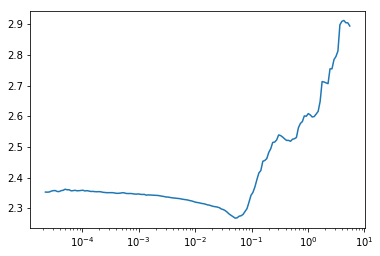

In [136]:
learn.plot()

In [137]:
model = Darknet([1, 2, 4, 6, 3], num_classes=10, nf=16)
learn = Learner(data, model)
sched = OneCycleScheduler(learn, 1e-2, 30)

In [138]:
learn.fit(30,1e-2,callbacks=[sched])

0 1.3797497730255126


1 1.2405124612808227


2 1.0517192411422729


3 0.8866207328796387


4 0.868588837814331


5 0.7997252022743225


6 0.7281511748313904


7 0.6490386340141296


8 0.6042229343414307


9 0.5869660574913025


12 0.5751848895549774


13 0.5049685458183288


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16 0.542769478559494


17 0.47914639835357664


18 0.4610725922584534


19 0.46900337715148926


20 0.44952573056221007


21 0.4274751099348068


22 0.4490983438491821


23 0.4004989989757538


24 0.39178929266929624


25 0.38540481214523314


26 0.35978117985725405


27 0.36213245701789853


28 0.3526930498123169


29 0.35215723090171813


In [139]:
def accuracy(mode, dl):
    match, count = 0, 0
    with torch.no_grad(): 
        for x,y in dl:
            z = model(x)
            preds = z.argmax(1)
            count += y.size(0)
            match += (preds==y).long().sum().item()
    return match/count

In [140]:
accuracy(learn.model, learn.data.valid_dl)

0.89

## AdamW

In [141]:
class TrueWD(Callback):
    
    def __init__(self, learn, wd):
        self.learn,self.wd = learn,wd
        
    def on_train_begin(self):
        self.opt = self.learn.opt
        self.opt.wd = 0.
    
    def on_backward_end(self):
        for pg in self.opt.param_groups():
            lr = pg['lr']
            for p in pg['params']:
                p.data.mul_(1 - lr * self.wd)

In [144]:
model = Darknet([1, 2, 4, 6, 3], num_classes=10, nf=16)
learn = Learner(data, model)
learn.opt_fn = partial(optim.Adam, betas=(0.95,0.99))

In [145]:
learn.lr_find()

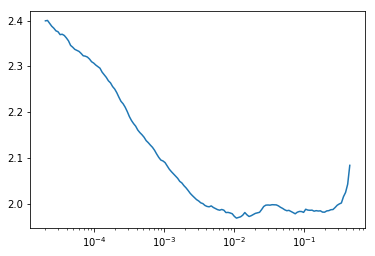

In [146]:
learn.plot()

In [149]:
model = Darknet([1, 2, 4, 6, 3], num_classes=10, nf=16)
learn = Learner(data, model)
scheds = [OneCycleScheduler(learn, 1e-2, 30), TrueWD(learn,0.1)]

In [150]:
learn.fit(30,1e-2,callbacks=scheds)

0 1.357192269897461


1 1.137924700164795


2 1.026493391418457


3 1.2143852317333221


4 0.9028418331146241


5 0.8261163204669952


6 0.7483424302101135


7 0.6128894603729248


8 0.6736960613250732


9 0.6578121648788452


10 0.58171232380867


11 0.5944612268924713


12 0.5808580270767212


13 0.5363604610919952


14 0.4643016966819763


15 0.505689626789093


16 0.5178360108375549


17 0.47762669286727905


18 0.4363456547737122


19 0.43688819646835325


20 0.4641410561800003


21 0.4149269449234009


22 0.40350703473091126


23 0.4138778009414673


24 0.40640733337402346


25 0.38051321959495543


26 0.3681526861190796


27 0.36146978011131287


28 0.35961990618705747


29 0.35494073314666746


In [151]:
accuracy(learn.model, learn.data.valid_dl)

0.89